In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/11 - Deep Learning/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/11 - Deep Learning


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lib.lr_utils import load_dataset

# Data Loading

In [ ]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

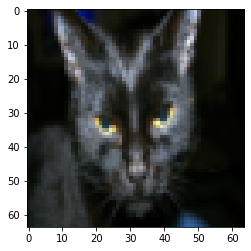

In [ ]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index]);

In [ ]:
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)


In [ ]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print(train_set_x_flatten.shape)
print(test_set_x_flatten.shape)

(12288, 209)
(12288, 50)


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [ ]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

# General Architecture of the learning algorithm

The data shape is reversed in the example. X(m, N) --> X(N, m)

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## Sigmoid Function

In [ ]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [ ]:
sigmoid(np.array([0, 2]))

array([0.5       , 0.88079708])

## Initializing parameters


In [ ]:
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1))
    b = 0
    return w, b

In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print(w.shape)
print(b)

(2, 1)
0


## Forward and Backward propagation

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [ ]:
def propagate(w, b, X, Y):
    
    # forward propagation
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)      
    sum_error = np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))    
    cost = (-1/m) * sum_error   
    
    # backward propagation
    dw = (1/m) * np.dot(X, (A - Y).T)
    db = (1/m) * np.sum(A - Y)
    cost = np.squeeze(cost)    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [ ]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print(cost)
grads

5.801545319394553


{'db': 0.001455578136784208, 'dw': array([[0.99845601],
        [2.39507239]])}

## Optimization

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)        
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


## Prediction

In [ ]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X)+b)
    for i in range(A.shape[1]):
        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    return Y_prediction

In [ ]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2], [1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## Model Building

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs, 
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b, 
         "learning_rate" : learning_rate, 
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


## Evaluation

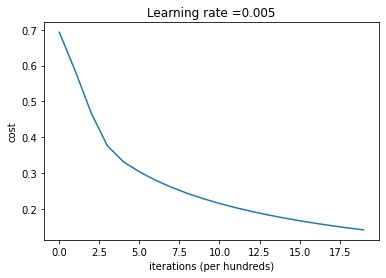

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



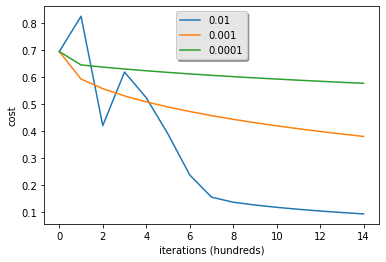

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c